In [33]:
import json
import os
import warnings
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize

import importlib
import utils  # Import your module
from utils import model_name_mapping, metrics_name_mapping

# After making changes to utils.py, reload it
importlib.reload(utils)

# filepath = Path(__file__).parent
filepath = Path(os.path.abspath(''))
print(filepath)

/nfs/ml_lab/projects/improve/data/experiments/csa_postproc_all


In [34]:
datadir = Path('splits_averaged')
outdir = datadir
input_for_llm_dir = Path('input_for_llm')

filename = 'all_models_scores.csv'
canc_col_name = "improve_sample_id"
drug_col_name = "improve_chem_id"

# datasets_order = ["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"]  # alphabetical order
datasets_order = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]  # order by sample size
show_plot = True

all_scores = pd.read_csv(filepath / datadir / filename, sep=',')
all_scores.iloc[:3,:]

,met,split,value,src,trg,model
0,mse,0,0.006295,CCLE,CCLE,deepcdr
1,mse,1,0.005950,CCLE,CCLE,deepcdr
2,mse,2,0.005129,CCLE,CCLE,deepcdr


In [35]:
# Specify the metric
metric_name = "r2"

# Specify the models you want to include
models_to_include = []  # Replace with your desired models
# models_to_include = ["deepcdr", "graphdrp", "hidra", "lgbm", "uno"]  # Replace with your desired models
# models_to_include = ["graphdrp"]  # Replace with your desired models

In [36]:
# # Average across splits
# sc_mean = all_scores.groupby(['met', 'src', 'trg', 'model'])['value'].mean().reset_index()
# sc_std = all_scores.groupby(['met', 'src', 'trg', 'model'])['value'].std().reset_index()
# sc_mean[:3]

# Within-study results

In [37]:
# Extract all within-study results (src == trg)
df = all_scores[
    (all_scores["met"] == metric_name) & 
    (all_scores["src"] == all_scores["trg"])  # src == trg
].reset_index(drop=True)
print(df.shape)
df.head()

df = df.groupby(["model", "src"]).agg(mean_splits=("value", "mean"), std_splits=("value", "std")).reset_index()

df_mean = df.sort_values(by=["src", "mean_splits"], ascending=[True, False]).reset_index(drop=True)  # compute mean
df_std = df.sort_values(by=["src", "std_splits"], ascending=[True, False]).reset_index(drop=True)    # compute std
# display(df.iloc[:7,:])

# Mean across splits
df_mean = df_mean.pivot(index="src", columns="model", values="mean_splits")#.reset_index(drop=False)
df_mean.index.name = None
df_mean.columns.name = None
df_mean = df_mean.T
df_mean = df_mean.round(3)
df_mean.index = df_mean.index.map(model_name_mapping)
df_mean = df_mean[datasets_order]
display(df_mean)

# Std across splits
df_std = df_std.pivot(index="src", columns="model", values="std_splits")#.reset_index(drop=False)
df_std.index.name = None
df_std.columns.name = None
df_std = df_std.T
df_std = df_std.round(3)
df_std.index = df_std.index.map(model_name_mapping)
df_std = df_std[datasets_order]
display(df_std)

# display(df_mean.mean(axis=1))
# display(df_mean.mean(axis=0))
# display(df_std.mean(axis=1))
# display(df_std.mean(axis=0))

(300, 6)


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.720,0.766,0.760,0.704,0.811
GraphDRP,0.736,0.746,0.765,0.733,0.855
HiDRA,0.711,0.756,0.768,0.722,0.832
LGBM,0.782,0.801,0.764,0.695,0.784
tCNNS,0.591,0.705,0.648,0.575,0.639
UNO,0.774,0.796,0.775,0.738,0.841


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.020,0.023,0.007,0.008,0.005
GraphDRP,0.029,0.018,0.008,0.007,0.006
HiDRA,0.027,0.020,0.011,0.007,0.005
LGBM,0.020,0.011,0.008,0.006,0.003
tCNNS,0.061,0.049,0.052,0.049,0.063
UNO,0.025,0.012,0.007,0.007,0.006


In [38]:
display(df_mean)

# Add new row to df_mean containing the mean of each column
datasets_mean = df_mean.mean(axis=0)
df_mean.loc['Mean of datasets'] = datasets_mean

# Add new column to df_mean containing the mean of each row
models_mean = df_mean.mean(axis=1)
df_mean['Mean of models'] = models_mean

# Assign NA to cell of (mean_dataset, mean_model)
df_mean.loc['Mean of datasets', 'Mean of models'] = np.nan

display(df_mean)

,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.720,0.766,0.760,0.704,0.811
GraphDRP,0.736,0.746,0.765,0.733,0.855
HiDRA,0.711,0.756,0.768,0.722,0.832
LGBM,0.782,0.801,0.764,0.695,0.784
tCNNS,0.591,0.705,0.648,0.575,0.639
UNO,0.774,0.796,0.775,0.738,0.841


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2,Mean of models
DeepCDR,0.720,0.766000,0.760000,0.7040,0.811000,0.7522
GraphDRP,0.736,0.746000,0.765000,0.7330,0.855000,0.7670
HiDRA,0.711,0.756000,0.768000,0.7220,0.832000,0.7578
LGBM,0.782,0.801000,0.764000,0.6950,0.784000,0.7652
tCNNS,0.591,0.705000,0.648000,0.5750,0.639000,0.6316
UNO,0.774,0.796000,0.775000,0.7380,0.841000,0.7848
Mean of datasets,0.719,0.761667,0.746667,0.6945,0.793667,NaN


In [39]:
display(df_std)

# Add new row to df_mean containing the mean of each column
datasets_std = df_std.mean(axis=0)
df_std.loc['Mean of datasets'] = datasets_std

# Add new column to df_mean containing the mean of each row
models_std = df_std.mean(axis=1)
df_std['Mean of models'] = models_std

# Assign NA to cell of (mean_dataset, mean_model)
df_std.loc['Mean of datasets', 'Mean of models'] = np.nan

display(df_std)

,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2
DeepCDR,0.020,0.023,0.007,0.008,0.005
GraphDRP,0.029,0.018,0.008,0.007,0.006
HiDRA,0.027,0.020,0.011,0.007,0.005
LGBM,0.020,0.011,0.008,0.006,0.003
tCNNS,0.061,0.049,0.052,0.049,0.063
UNO,0.025,0.012,0.007,0.007,0.006


,gCSI,CCLE,GDSCv2,GDSCv1,CTRPv2,Mean of models
DeepCDR,0.020000,0.023000,0.0070,0.008,0.005000,0.0126
GraphDRP,0.029000,0.018000,0.0080,0.007,0.006000,0.0136
HiDRA,0.027000,0.020000,0.0110,0.007,0.005000,0.0140
LGBM,0.020000,0.011000,0.0080,0.006,0.003000,0.0096
tCNNS,0.061000,0.049000,0.0520,0.049,0.063000,0.0548
UNO,0.025000,0.012000,0.0070,0.007,0.006000,0.0114
Mean of datasets,0.030333,0.022167,0.0155,0.014,0.014667,NaN


In [40]:
datasets_mean

gCSI      0.719000
CCLE      0.761667
GDSCv2    0.746667
GDSCv1    0.694500
CTRPv2    0.793667
dtype: float64

In [41]:
models_mean

DeepCDR             0.7522
GraphDRP            0.7670
HiDRA               0.7578
LGBM                0.7652
tCNNS               0.6316
UNO                 0.7848
Mean of datasets    0.7431
dtype: float64

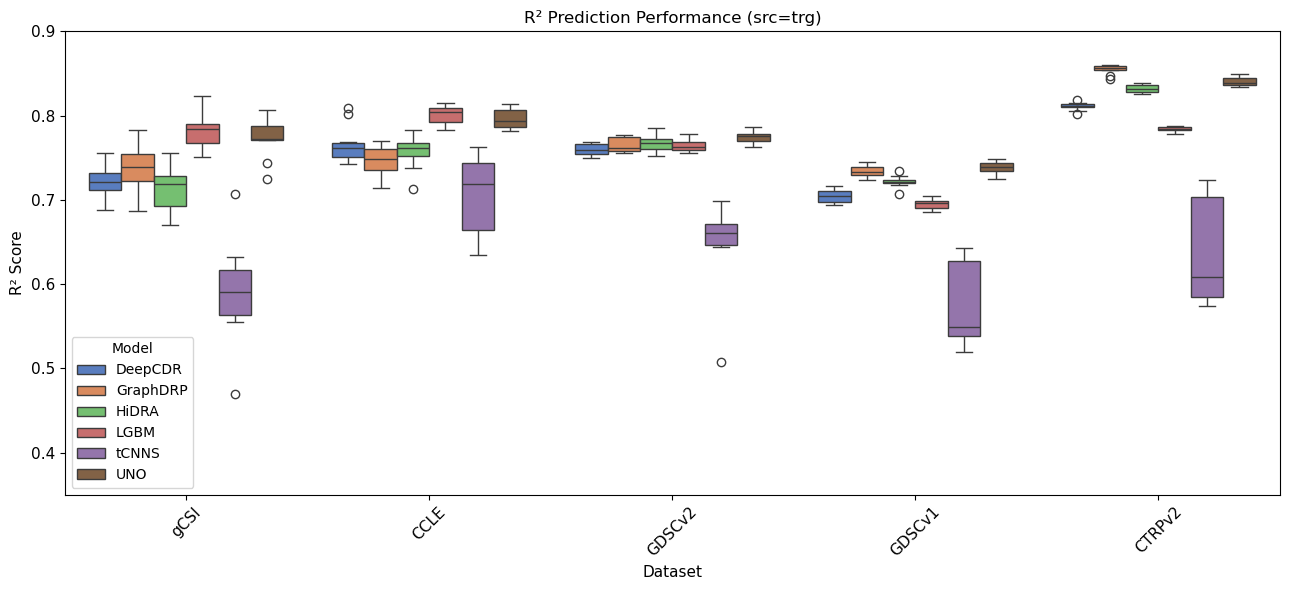

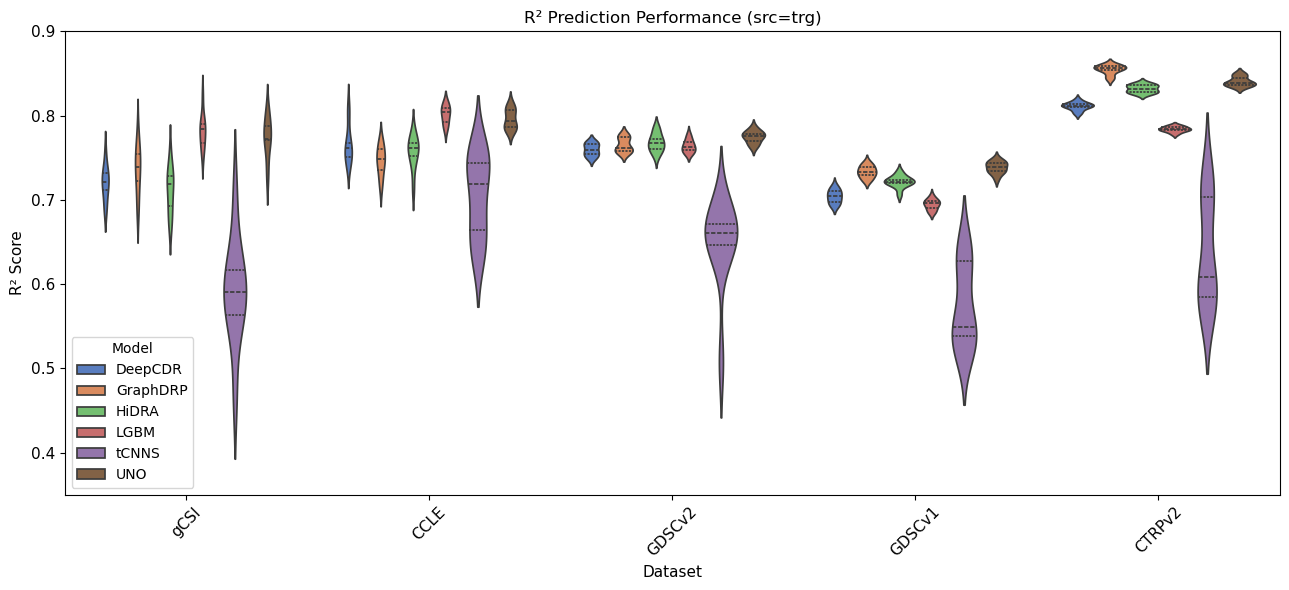

In [42]:
# --------------------------------------------------------------------------------------
## Performance for all models and datasets (src = trg)
# --------------------------------------------------------------------------------------

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

filtered_data = all_scores[
    (all_scores["model"].isin(models_to_include)) & 
    (all_scores["met"] == metric_name) & 
    (all_scores["src"] == all_scores["trg"])
].reset_index(drop=True)

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

utils.boxplot_violinplot_within_study(
    df=filtered_data, 
    metric_name=metric_name, 
    models_to_include=models_to_include, 
    outdir=outdir,
    ymin=0.35,
    ymax=0.9,
    datasets_order=datasets_order
)

del filtered_data

/tmp/ipykernel_1457852/2468863530.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['model'] = filtered_data['model'].map(model_name_mapping)


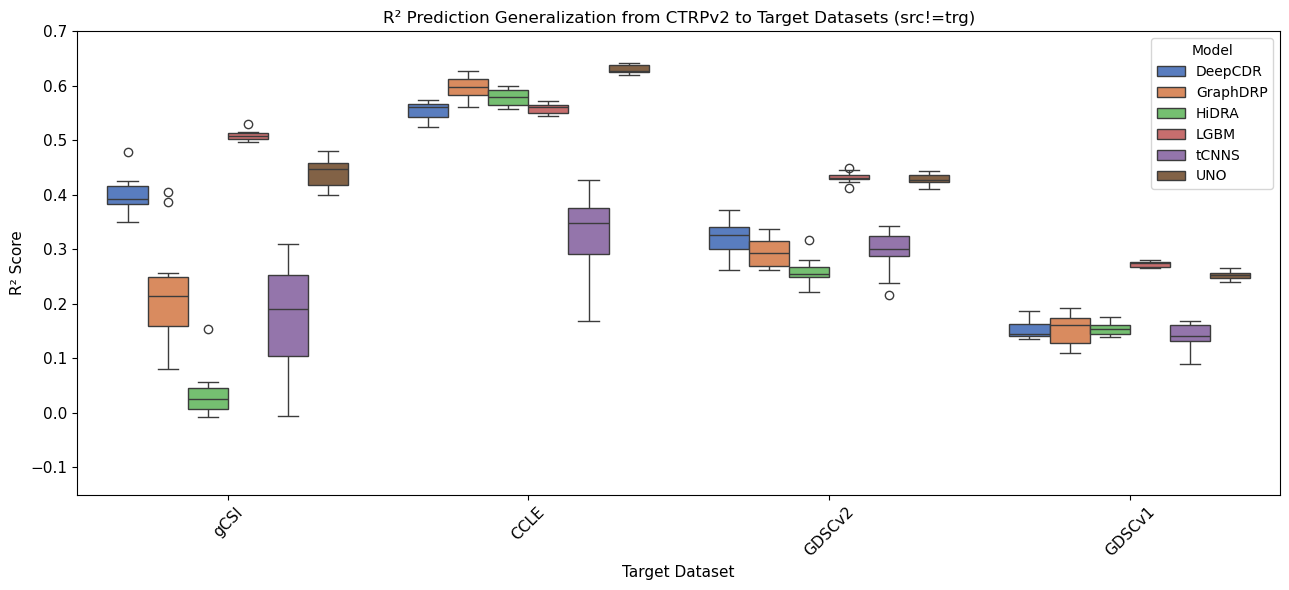

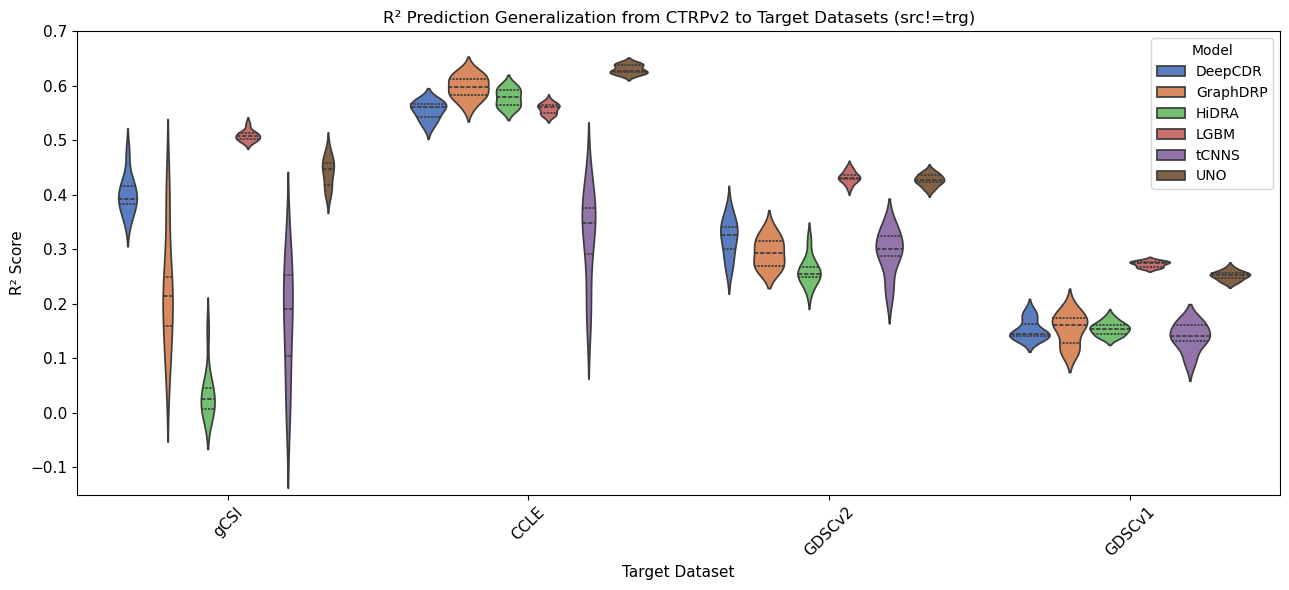

In [43]:
# --------------------------------------------------------------------------------------
## Performance from specific source to all targets (src != trg)
# --------------------------------------------------------------------------------------

# Specify the source dataset for filtering
source_dataset = "CTRPv2"  # Replace with the specific source dataset

if len(models_to_include) == 0:
    models_to_include = all_scores["model"].unique()

# Filter data for specific source dataset (src = CTRPv2), and R^2 metric
filtered_data = all_scores[
    (all_scores["src"] == source_dataset) &
    (all_scores["src"] != all_scores["trg"]) &  # Exclude cases where src = trg
    (all_scores["met"] == metric_name) &
    (all_scores["model"].isin(models_to_include))  # Include only specified models
]

# Map the model names to their corresponding names using model_name_mapping
filtered_data['model'] = filtered_data['model'].map(model_name_mapping)

utils.boxplot_violinplot_cross_study(
    df=filtered_data, 
    source_dataset=source_dataset, 
    metric_name=metric_name, 
    models_to_include=models_to_include, 
    outdir=outdir,
    ymin=-0.15,
    ymax=0.7,
    datasets_order=[x for x in datasets_order if x != source_dataset]
)

del filtered_data

In [44]:
# # Basic CSA Table (single model, single metric)

# model_name = "graphdrp"

# mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
# std_csa_filename = f'{model_name}_{metric_name}_std_csa_table.csv'

# scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
# std_csa_data = pd.read_csv(filepath / datadir / std_csa_filename, sep=',')

# scores_csa_data.set_index("src", inplace=True)
# std_csa_data.set_index("src", inplace=True)

# display(scores_csa_data)
# display(std_csa_data)

# del model_name

deepcdr


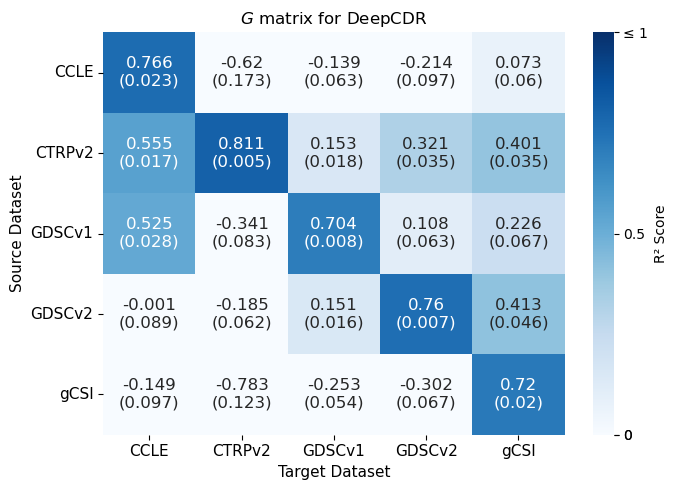

graphdrp


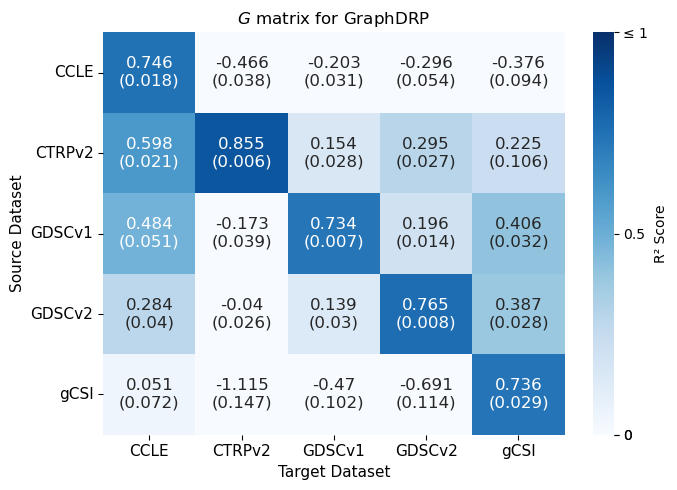

hidra


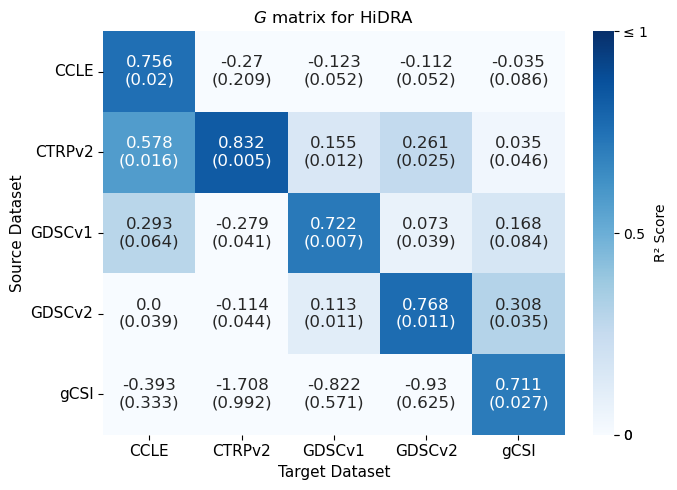

lgbm


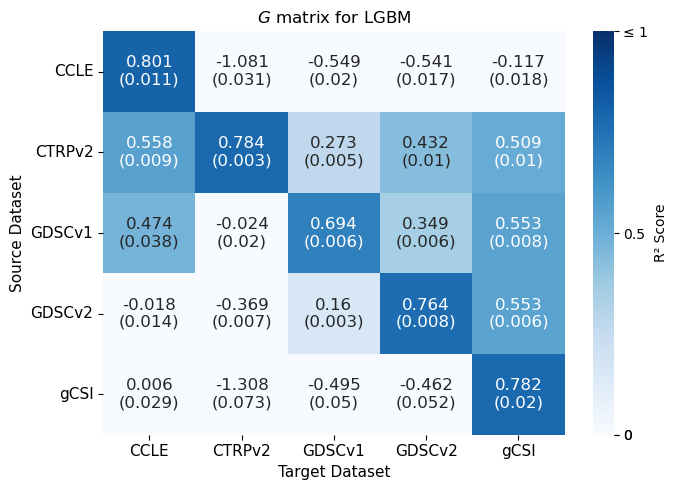

tcnns


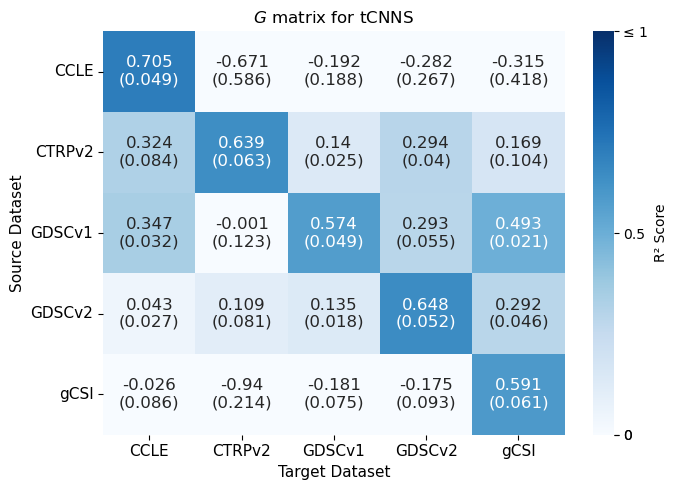

uno


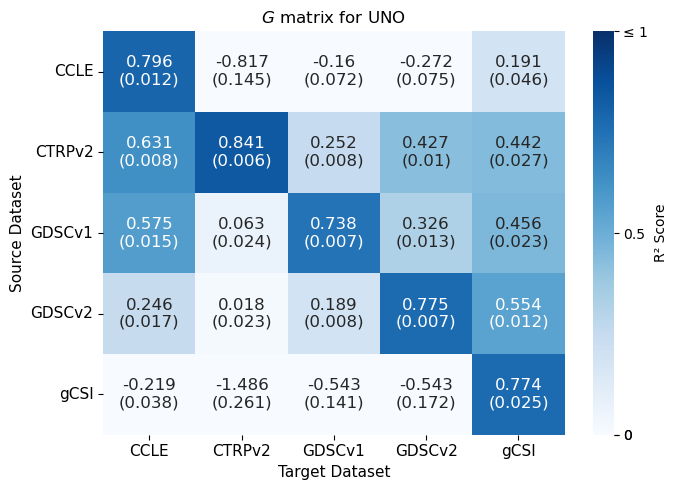

In [45]:
# CSA Scores with Standard Deviations (Linear Scale)

csa_scores_dfs = {}
csa_stds_dfs = {}

for model_name in model_name_mapping.keys():
    print(model_name)
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    std_csa_filename = f'{model_name}_{metric_name}_std_csa_table.csv'

    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    std_csa_data = pd.read_csv(filepath / datadir / std_csa_filename, sep=',')

    scores_csa_data.set_index("src", inplace=True)
    std_csa_data.set_index("src", inplace=True)

    # Save csv for llm
    scores_csa_data.to_csv(input_for_llm_dir / f'{model_name}_{metric_name}_G_mean.csv')
    std_csa_data.to_csv(input_for_llm_dir / f'{model_name}_{metric_name}_G_std.csv')

    csa_scores_dfs[model_name] = scores_csa_data
    csa_stds_dfs[model_name] = std_csa_data

    utils.csa_heatmap(
        model_name=model_name, 
        metric_name=metric_name,
        csa_metric_name='G',
        scores_csa_data=scores_csa_data, 
        std_csa_data=std_csa_data,
        vmin=0,
        vmax=1,
        outdir=outdir,
        decimal_digits=3,
        show=show_plot
    )

del model_name, scores_csa_data, std_csa_data

In [47]:
# Print the basic CSA tables (G matrix)

model_id = 0
model_name = list(csa_scores_dfs.keys())[model_id]

scores_csa_data = csa_scores_dfs[model_name]
scores_csa_data.index.name = None
scores_csa_data.columns.name = None

std_csa_data = csa_stds_dfs[model_name]
std_csa_data.index.name = None
std_csa_data.columns.name = None

print(f'{model_name} r2 scores')
print(scores_csa_data)

print(f'{model_name} r2 stds')
print(std_csa_data) 

deepcdr r2 scores
          CCLE  CTRPv2  GDSCv1  GDSCv2    gCSI
CCLE    0.7659 -0.6201 -0.1386 -0.2136  0.0733
CTRPv2  0.5553  0.8113  0.1530  0.3208  0.4012
GDSCv1  0.5246 -0.3413  0.7041  0.1080  0.2255
GDSCv2 -0.0014 -0.1850  0.1506  0.7597  0.4129
gCSI   -0.1487 -0.7832 -0.2529 -0.3016  0.7196
deepcdr r2 stds
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
CCLE    0.022527  0.172747  0.062589  0.097393  0.059583
CTRPv2  0.016738  0.004681  0.018039  0.034644  0.035381
GDSCv1  0.028221  0.083203  0.007961  0.062702  0.066626
GDSCv2  0.088769  0.061822  0.015626  0.007224  0.046317
gCSI    0.096921  0.122918  0.053705  0.066701  0.020394


In [48]:
# # --------------------------------------------------------------------------------------
# ## CSA Scores with Standard Deviations (Discrete Levels Same Color)
# # --------------------------------------------------------------------------------------

# # Define discrete levels and custom colormap
# levels = [-1e6, 0, 0.25, 0.5, 0.7, 1]
# colors = ["#08306b", "#2171b5", "#6baed6", "#bdd7e7", "#eff3ff"]
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(boundaries=levels, ncolors=len(colors))

# # Combine scores and stds for annotations
# combined_annotations = scores_csa_data.round(4).astype(str) + "\n(" + std_csa_data.round(4).astype(str) + ")"

# # Plot the combined heatmap
# plt.figure(figsize=(7, 5))
# sns.heatmap(
# scores_csa_data, 
#     annot=combined_annotations.values, 
#     fmt="", 
#     cmap=cmap, 
#     norm=norm, 
#     cbar_kws={'label': 'R² Score'}
# )

# # Customize colorbar ticks to align with levels
# colorbar = plt.gca().collections[0].colorbar
# colorbar.set_ticks(levels[1:])  # Exclude the placeholder -1e6
# colorbar.set_ticklabels(["< 0", "0-0.25", "0.25-0.5", "0.5-0.7", "> 0.7"])  # Custom labels

# plt.title("CSA Performance Scores with Standard Deviations (Discrete Levels)")
# plt.xlabel("Target Dataset")
# plt.ylabel("Source Dataset")
# plt.tight_layout()
# plt.show()

# # --------------------------------------------------------------------------------------
# ## CSA Scores with Standard Deviations (Discrete Levels Different Colors)
# # --------------------------------------------------------------------------------------

# # Define custom levels and pale colors
# levels = [-1e6, 0, 0.25, 0.5, 0.7, 1]  # Replace -float("inf") with a very small value
# colors = ["#dcd0ff", "#ffd1d1", "#ffebcc", "#ffffcc", "#d1ffd1"]  # Pale purple, red, orange, yellow, green
# cmap = ListedColormap(colors)
# norm = BoundaryNorm(boundaries=levels, ncolors=len(colors))

# # Plot heatmap
# plt.figure(figsize=(7, 5))
# sns.heatmap(scores_csa_data, annot=True, fmt=".2f", cmap=cmap, norm=norm, cbar_kws={'label': 'R² Score'})

# # Customize colorbar ticks to align with levels
# colorbar = plt.gca().collections[0].colorbar
# colorbar.set_ticks(levels[1:])  # Exclude the placeholder -1e6
# colorbar.set_ticklabels(["< 0", "0-0.25", "0.25-0.5", "0.5-0.7", "> 0.7"])  # Custom labels

# # Finalize plot
# plt.title("CSA Performance Scores with Standard Deviations (Discrete Levels)")
# plt.xlabel("Target Dataset")
# plt.ylabel("Source Dataset")
# plt.tight_layout()
# plt.show()

# Custom metrics

In [49]:
# # Example CSA scores (R²)
# scores_csa_data = {
#     "CCLE": [0.7479, 0.5758, 0.4482, 0.3082, 0.0234],
#     "CTRPv2": [-0.4671, 0.8508, -0.1432, -0.0324, -1.1319],
#     "GDSCv1": [-0.2057, 0.1503, 0.734, 0.154, -0.4801],
#     "GDSCv2": [-0.2913, 0.2902, 0.2003, 0.7659, -0.7147],
#     "gCSI": [-0.3793, 0.2314, 0.4179, 0.3914, 0.733],
# }
# scores_csa_data = pd.DataFrame(scores_csa_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

# # Example CSA std deviations (optional for some metrics)
# std_csa_data = {
#     "CCLE": [0.0123, 0.0406, 0.0245, 0.0364, 0.1058],
#     "CTRPv2": [0.0249, 0.0031, 0.0135, 0.0253, 0.0901],
#     "GDSCv1": [0.078, 0.0301, 0.0065, 0.0389, 0.0304],
#     "GDSCv2": [0.0453, 0.0216, 0.0262, 0.0098, 0.0448],
#     "gCSI": [0.1053, 0.1546, 0.0903, 0.1144, 0.0314],
# }
# std_csa_data = pd.DataFrame(std_csa_data, index=["CCLE", "CTRPv2", "GDSCv1", "GDSCv2", "gCSI"])

model_name = "graphdrp"

mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
std_csa_filename = f'{model_name}_{metric_name}_std_csa_table.csv'

scores = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
stds = pd.read_csv(filepath / datadir / std_csa_filename, sep=',')

scores.set_index("src", inplace=True)
stds.set_index("src", inplace=True)

display(scores)
display(stds)

,CCLE,CTRPv2,GDSCv1,GDSCv2,gCSI
src,,,,,
CCLE,0.7463,-0.4658,-0.2034,-0.2956,-0.3757
CTRPv2,0.5975,0.8548,0.1536,0.2946,0.2248
GDSCv1,0.4837,-0.1727,0.7335,0.1963,0.4063
GDSCv2,0.2838,-0.0400,0.1392,0.7654,0.3867
gCSI,0.0507,-1.1147,-0.4700,-0.6911,0.7359


,CCLE,CTRPv2,GDSCv1,GDSCv2,gCSI
src,,,,,
CCLE,0.017624,0.037721,0.031389,0.053909,0.094062
CTRPv2,0.020908,0.005561,0.028340,0.026835,0.105501
GDSCv1,0.051223,0.039108,0.007105,0.013770,0.032113
GDSCv2,0.039580,0.025730,0.029556,0.008478,0.027771
gCSI,0.072315,0.146593,0.102085,0.113874,0.029452


# Source-to-Target Generalization Ratio (STGR)

In [17]:
# Compute STGR using both implementations
stgr_bruteforce = utils.compute_stgr_bruteforce(scores)
stgr_vectorized = utils.compute_stgr_vectorized(scores)

# Convert bruteforce results to DataFrame for comparison
stgr_bruteforce_df = pd.DataFrame.from_dict(stgr_bruteforce, orient="index")

# Compare results
print("Bruteforce STGR:")
print(stgr_bruteforce_df)

print("\nVectorized STGR:")
print(stgr_vectorized)

# Check for equality
assert np.allclose(stgr_bruteforce_df, stgr_vectorized), "STGR results do not match!"
print("\nBoth implementations produce the same results!")

Bruteforce STGR:
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
CCLE    1.000000 -0.624146 -0.272545 -0.396087 -0.503417
CTRPv2  0.698994  1.000000  0.179691  0.344642  0.262985
GDSCv1  0.659441 -0.235446  1.000000  0.267621  0.553920
GDSCv2  0.370787 -0.052260  0.181866  1.000000  0.505226
gCSI    0.068895 -1.514744 -0.638674 -0.939122  1.000000

Vectorized STGR:
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
src                                                     
CCLE    1.000000 -0.624146 -0.272545 -0.396087 -0.503417
CTRPv2  0.698994  1.000000  0.179691  0.344642  0.262985
GDSCv1  0.659441 -0.235446  1.000000  0.267621  0.553920
GDSCv2  0.370787 -0.052260  0.181866  1.000000  0.505226
gCSI    0.068895 -1.514744 -0.638674 -0.939122  1.000000

Both implementations produce the same results!


deepcdr


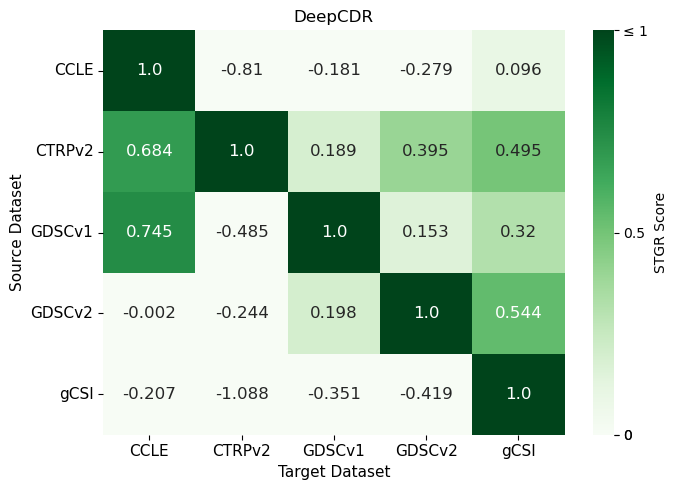

graphdrp


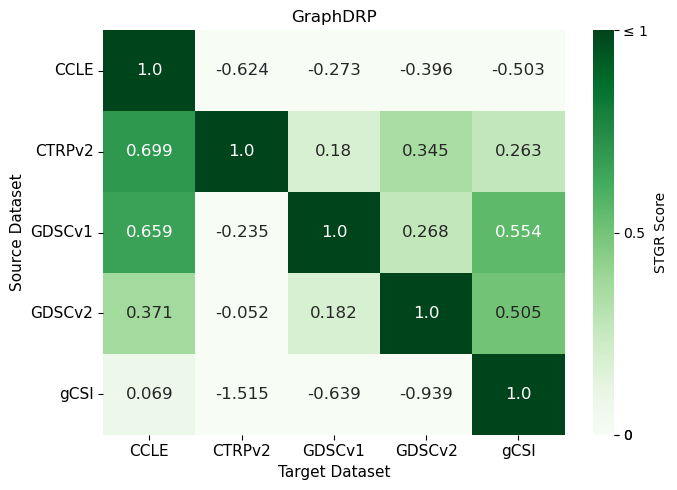

hidra


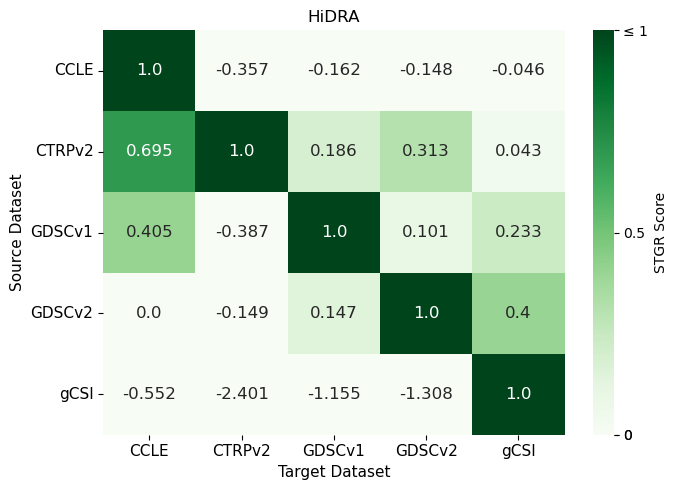

lgbm


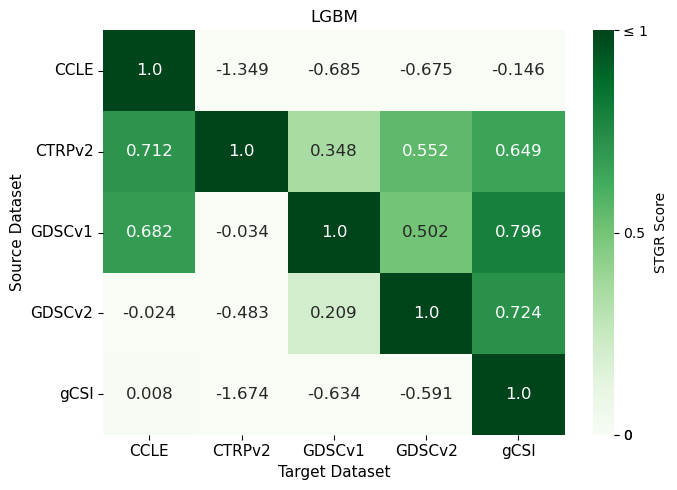

tcnns


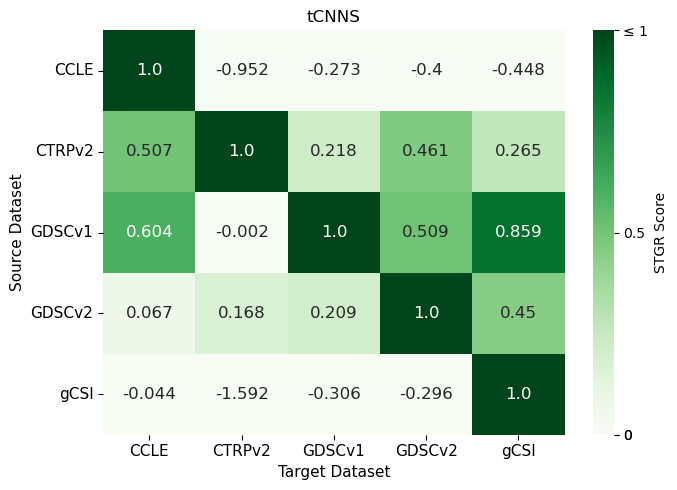

uno


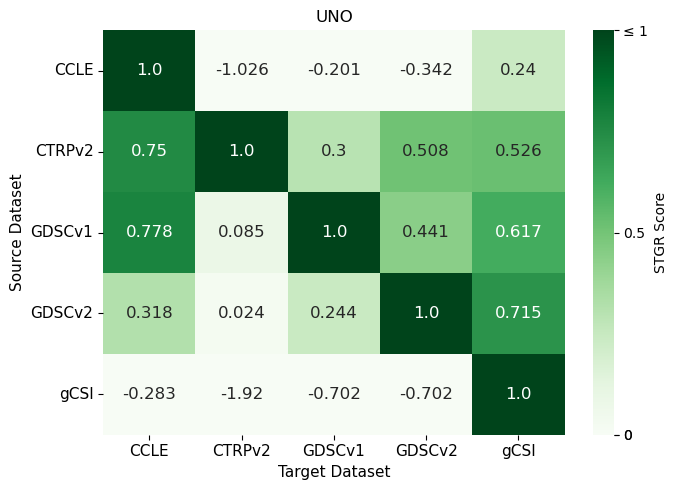

In [18]:
for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    scores_csa_data.set_index("src", inplace=True)
    stgr = utils.compute_stgr_vectorized(scores_csa_data)

    utils.csa_heatmap(
        model_name=model_name, 
        metric_name="stgr", 
        scores_csa_data=stgr, 
        vmin=0,
        vmax=1,
        palette="Greens",
        outdir=outdir,
        decimal_digits=3,
        show=show_plot
    )

del model_name, scores_csa_data, stgr

In [19]:
# Print SPGR tables

model_id = 5
model_name = list(csa_scores_dfs.keys())[model_id]

scores_csa_data = csa_scores_dfs[model_name]

stgr = utils.compute_stgr_vectorized(scores_csa_data)
stgr.index.name = None
stgr.columns.name = None

print(f'{model_name} stgr')
print(stgr)

uno stgr
            CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
CCLE    1.000000 -1.025876 -0.200980 -0.342168  0.240296
CTRPv2  0.750327  1.000000  0.299750  0.508386  0.525514
GDSCv1  0.778334  0.085173  1.000000  0.441165  0.617468
GDSCv2  0.317630  0.023748  0.244192  1.000000  0.715023
gCSI   -0.282502 -1.919747 -0.702119 -0.702119  1.000000


# Source-to-Target Generalization Index (STGI)

In [20]:
# Compute STGR using both implementations
stgi_bruteforce = utils.compute_stgi_bruteforce(scores)
stgi_vectorized = utils.compute_stgi_vectorized(scores)

# Compare results
print("Bruteforce STGI:")
print(stgi_bruteforce)

print("\nVectorized STGI:")
print(stgi_vectorized)

# Check if all implementations are consistent
# assert stgi_vectorized.equals(pd.Series(stgi_bruteforce)), "Mismatch between bruteforce and simpler implementations!"
assert stgi_vectorized == stgi_bruteforce, "Mismatch between bruteforce and vectorized implementations!"

Bruteforce STGI:
{'CCLE': -0.44904863995712174, 'CTRPv2': 0.3715781469349555, 'GDSCv1': 0.31138377641445125, 'GDSCv2': 0.2514044943820225, 'gCSI': -0.7559111292295149}

Vectorized STGI:
{'CCLE': -0.44904863995712174, 'CTRPv2': 0.3715781469349555, 'GDSCv1': 0.31138377641445125, 'GDSCv2': 0.2514044943820225, 'gCSI': -0.7559111292295149}


In [21]:
stgi_list = []

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    scores_csa_data.set_index("src", inplace=True)
    stgi = utils.compute_stgi_vectorized(scores_csa_data)

    stgi['model'] = model_name
    # print(stgi)
    stgi_list.append(stgi)

stgi_df = pd.DataFrame(stgi_list)
stgi_df.insert(loc=0, column='model', value=stgi_df.pop('model')) # place 'model' col at pos 0
stgi_df.set_index("model", inplace=True)
stgi_df.to_csv(filepath / datadir / 'stgi_table.csv')
print(stgi_df)

del model_name, scores_csa_data, stgi, stgi_list

deepcdr
graphdrp
hidra
lgbm
tcnns
uno
              CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
model                                                     
deepcdr  -0.293446  0.440743  0.183497  0.124095 -0.516398
graphdrp -0.449049  0.371578  0.311384  0.251404 -0.755911
hidra    -0.178387  0.309188  0.088044  0.099831 -1.354035
lgbm     -0.713720  0.565274  0.486753  0.106694 -0.722588
tcnns    -0.518019  0.362903  0.492385  0.223388 -0.559369
uno      -0.332182  0.520994  0.480535  0.325148 -0.901622


In [22]:
# sns_palettes = ["coolwarm", "RdBu", "RdYlBu", "RdYlGn", "Spectral"]

# for palette in sns_palettes:
#     utils.stgi_heatmap(
#         metric_name="stgi",
#         scores_stgi_data=stgi_df.copy(),
#         palette=palette,
#         vmin=0,
#         vmax=1,
#         outdir=outdir,
#         show=show_plot
#     )


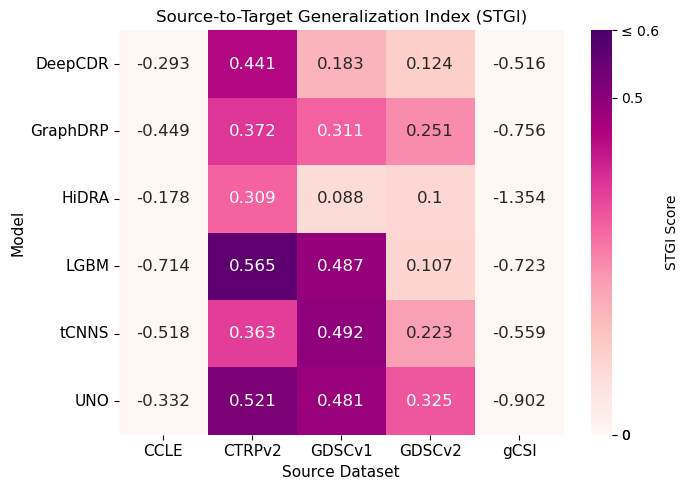

In [23]:
utils.stgi_heatmap(
    metric_name="stgi",
    scores_stgi_data=stgi_df.copy(),
    palette="RdPu",
    vmin=0,
    vmax=0.6,
    outdir=outdir,
    show=show_plot
)

In [25]:
# palette = "RdGn"

# if palette in plt.colormaps():  # Check if the palette is a valid Matplotlib colormap
#     cmap = plt.get_cmap(palette)
# else:
#     cmap = sns.color_palette(palette, as_cmap=True)  # Use Seaborn for custom palettes

# print(cmap)

In [27]:
# palette in plt.colormaps()

In [33]:
   available_colormaps = plt.colormaps()
   print(available_colormaps)

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

In [29]:
# import matplotlib
# matplotlib.__version__

In [31]:
csm_list = []

for model_name in model_name_mapping.keys():
    print(model_name)
    
    mean_csa_filename = f'{model_name}_{metric_name}_mean_csa_table.csv'
    scores_csa_data = pd.read_csv(filepath / datadir / mean_csa_filename, sep=',')
    scores_csa_data.set_index("src", inplace=True)
    csm = utils.compute_stgi_vectorized(scores_csa_data, normalize = False)

    csm['model'] = model_name
    # print(stgi)
    csm_list.append(csm)

csm_df = pd.DataFrame(csm_list)
csm_df.insert(loc=0, column='model', value=csm_df.pop('model')) # place 'model' col at pos 0
csm_df.set_index("model", inplace=True)
csm_df.to_csv(filepath / datadir / 'csm_table.csv')
print(csm_df)

# del model_name, scores_csa_data, stgi, stgi_list

deepcdr
graphdrp
hidra
lgbm
tcnns
uno
              CCLE    CTRPv2    GDSCv1    GDSCv2      gCSI
model                                                     
deepcdr  -0.224750  0.357575  0.129200  0.094275 -0.371600
graphdrp -0.335125  0.317625  0.228400  0.192425 -0.556275
hidra    -0.134950  0.257275  0.063550  0.076700 -0.963125
lgbm     -0.571975  0.443175  0.338050  0.081525 -0.564775
tcnns    -0.365100  0.231750  0.282875  0.144800 -0.330475
uno      -0.264450  0.438000  0.354875  0.251925 -0.697675


KeyError: 'csm'

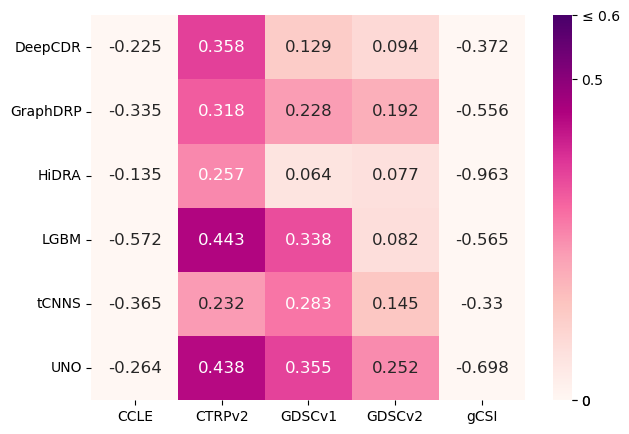

In [32]:
utils.stgi_heatmap(
    metric_name="csm",
    scores_stgi_data=csm_df.copy(),
    palette="Blues",
    vmin=0,
    vmax=0.6,
    outdir=outdir,
    show=show_plot
)

# Source-to-Target Variability Ratio (STVR)

In [ ]:
# STVR (Source-to-Target Variability Ratio)
"""
The STVR quantifies the relative variability of a model’s performance for a 
source-target pair by comparing the variability (standard deviation) of 
predictions to the average performance for that pair. It is designed to provide 
insight into the stability of predictions across different source-target combinations.

STVR evaluates stability per source-target pair, telling you how consistent or 
erratic the model predictions are in that scenario.

Key Characteristics
    - Pairwise Metric: Evaluates the variability for each source-target combination,
        enabling fine-grained analysis of prediction stability.
    - Normalization: Normalizes the standard deviation of predictions by the mean 
        performance, allowing for direct comparison across source-target pairs, 
        regardless of scale.
    - Interpretation
        - > 1: Indicates high variability relative to the average performance, 
            suggesting instability.
        - 0 < STVR < 1: Indicates low variability relative to the average performance, 
            suggesting stability.
        - < 0: Reflects variability relative to poor performance
    - Caveats
        - Sensitive to both variability (numerator) and performance (denominator): 
            Small mean performance values in the denominator can inflate the ratio,
            potentially misrepresenting variability.
        - Requires sufficient sample size for robust std computation.
    - Edge Cases
        - Zero mean performance: If mean_abs(src→trg)=0, assign a default value (e.g., 0) 
            to avoid division by zero.

Formula:
    STVR[src][trg] = std_dev(src → trg) / mean_score(src → trg)
    Where:
        - std_dev(src→trg): Standard deviation of predictions for the source-target pair.
        - mean_score(src→trg): Mean performance for the source-target pair.
"""

def compute_stvr_vectorized(scores, stds):
    """
    Compute STVR (Source-to-Target Variability Ratio) using a vectorized approach.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        pd.DataFrame: A DataFrame with STVR values for each source-target pair.
    """
    #mean_abs = scores.abs()  # Compute mean absolute score (element-wise)
    #stvr = stds / mean_abs.replace(0, np.nan)  # Compute STVR, avoiding division by zero
    stvr = stds / scores.replace(0, np.nan)  # Compute STVR, avoiding division by zero
    stvr = stvr.fillna(0)  # Replace NaN values with 0 for consistency
    return stvr


def compute_stvr_bruteforce(scores, stds):
    """
    Compute STVR (Source-to-Target Variability Ratio) for each source-target pair.
    This implementation avoids vectorized operations.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        pd.DataFrame: A DataFrame with STVR values for each source-target pair.
    """
    stvr = pd.DataFrame(index=scores.index, columns=scores.columns)

    # Iterate through each source-target pair
    for src in scores.index:
        for trg in scores.columns:
            # Get mean absolute score and std deviation
            #mean_abs = abs(scores.loc[src, trg])
            mena_score = scores.loc[src, trg]
            std_dev = stds.loc[src, trg]
            
            # Compute STVR
            #stvr.loc[src, trg] = std_dev / mean_abs if mean_abs != 0 else 0
            stvr.loc[src, trg] = std_dev / mena_score if mena_score != 0 else 0

    return stvr


stvr_bruteforce = compute_stvr_bruteforce(scores, stds).apply(pd.to_numeric)
stvr_vectorized = compute_stvr_vectorized(scores, stds).apply(pd.to_numeric)

print(stvr_bruteforce)
print(stvr_vectorized)

assert np.allclose(stvr_bruteforce.values, stvr_vectorized.values,
        atol=1e-6,  # Adjust the absolute tolerance for small rounding errors
        rtol=1e-5,   # Adjust the relative tolerance
        equal_nan=True), "STVR results do not match!"

# Source-to-Target Variability Index (STVI)

In [ ]:
# STVI (Source-to-Target Variability Index)
"""
STVI summarizes the variability of a model’s performance considering all 
source-target pairs and normalizing the overall variability (standard deviation) 
by the overall mean absolute performance.

STVI aggregates variability globally, helping you compare which models are more 
stable across the board, but not telling you which datasets or source-target 
pairs contribute to that stability or instability.
"""

def compute_stvi_vectorized(scores, stds):
    """
    Compute STVI (Source-to-Target Variability Index) using a vectorized approach.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        float: The STVI value for the entire CSA study.
    """
    mean_abs = scores.abs().mean().mean()  # Compute overall mean absolute score
    overall_std_dev = stds.values.std()  # Compute overall standard deviation of stds

    # Compute STVI
    return overall_std_dev / mean_abs if mean_abs != 0 else 0


def compute_stvi_bruteforce(scores, stds):
    """
    Compute STVI (Source-to-Target Variability Index) for the entire CSA study.
    This implementation avoids vectorized operations for a fully brute-force calculation.

    Args:
        scores (pd.DataFrame): DataFrame where each cell contains a performance score.
        stds (pd.DataFrame): DataFrame where each cell contains the standard deviation 
                             of scores for the corresponding source-target pair.

    Returns:
        float: The STVI value for the entire CSA study.
    """
    all_scores = []
    all_stds = []

    # Flatten all scores and std deviations
    for src in mean_csa_data.index:
        for trg in mean_csa_data.columns:
            all_scores.append(abs(mean_csa_data.loc[src, trg]))  # Collect absolute values of scores
            all_stds.append(std_csa_data.loc[src, trg])  # Collect standard deviations

    # Compute mean absolute score and overall standard deviation
    mean_abs = sum(all_scores) / len(all_scores)
    overall_std_dev = (sum((x - np.mean(all_stds)) ** 2 for x in all_stds) / len(all_stds)) ** 0.5

    # Compute STVI
    return overall_std_dev / mean_abs if mean_abs != 0 else 0


stvi_bruteforce = compute_stvi_bruteforce(mean_csa_data, std_csa_data)
stvi_vectorized = compute_stvi_vectorized(mean_csa_data, std_csa_data)

print(stvi_vectorized)
print(stvi_bruteforce)

assert np.isclose(stvi_bruteforce, stvi_vectorized, equal_nan=True), "STVI results do not match!"

# Runtime Analysis

In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # 1. Box Plot of Total Minutes by Model
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='model', y='tot_mins', data=df)
# plt.title('Box Plot of Total Minutes by Model')
# plt.xticks(rotation=45)
# plt.ylabel('Total Minutes')
# plt.xlabel('Model')
# plt.tight_layout()
# plt.show()

# # 2. Bar Plot of Average Total Minutes by Source
# avg_tot_mins_src = df.groupby('src')['tot_mins'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.barplot(x='src', y='tot_mins', data=avg_tot_mins_src)
# plt.title('Average Total Minutes by Source')
# plt.ylabel('Average Total Minutes')
# plt.xlabel('Source')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 3. Line Plot of Total Minutes by Stage
# avg_tot_mins_stage = df.groupby('stage')['tot_mins'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='stage', y='tot_mins', data=avg_tot_mins_stage, marker='o')
# plt.title('Average Total Minutes by Stage')
# plt.ylabel('Average Total Minutes')
# plt.xlabel('Stage')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 4. Heatmap of Total Minutes by Source and Target
# heatmap_data = df.pivot_table(values='tot_mins', index='src', columns='trg', aggfunc='mean')
# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
# plt.title('Heatmap of Average Total Minutes by Source and Target')
# plt.ylabel('Source')
# plt.xlabel('Target')
# plt.tight_layout()
# plt.show()

In [26]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
# stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# # Calculate the standard error of the mean (sem)
# stage_model_src_stats['sem'] = stage_model_src_stats['std'] / stage_model_src_stats['count'] ** 0.5

# # Define a color palette
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# # Create separate plots for each stage
# stages = stage_model_src_stats['stage'].unique()

# for stage in stages:
#     plt.figure(figsize=(14, 7))
#     stage_data = stage_model_src_stats[stage_model_src_stats['stage'] == stage]
    
#     bar_plot = sns.barplot(x='src', y='mean', hue='model', data=stage_data, palette=colors, errorbar=None)
    
#     # Add error bars for each bar
#     for index, bar in enumerate(bar_plot.patches):
#         height = bar.get_height()
#         sem = stage_data['sem'].iloc[index]
        
#         plt.errorbar(x=bar.get_x() + bar.get_width() / 2, 
#                      y=height, 
#                      yerr=sem, 
#                      fmt='none', 
#                      c='black', 
#                      capsize=5, 
#                      elinewidth=1)

#     plt.title(f'Distribution of Total Minutes for Stage {stage} with Error Bars')
#     plt.ylabel('Average Total Minutes')
#     plt.xlabel('Source')
#     plt.xticks(rotation=45)
#     plt.legend(title='Model')
#     plt.tight_layout()
#     plt.show()

In [24]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the data
# df = pd.read_csv('all_models_runtimes.csv')

# # Group by src, stage, and model, and calculate the mean and standard deviation of tot_mins
# stage_model_src_stats = df.groupby(['src', 'stage', 'model'])['tot_mins'].agg(['mean', 'std', 'count']).reset_index()

# # Create separate box plots for each stage
# stages = stage_model_src_stats['stage'].unique()

# # Define a color palette
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# for stage in stages:
#     plt.figure(figsize=(14, 7))
#     stage_data = df[df['stage'] == stage]  # Filter data for the current stage
    
#     # Create a box plot
#     sns.boxplot(x='src', y='tot_mins', hue='model', data=stage_data, palette=colors)
    
#     plt.title(f'Distribution of Total Minutes for Stage: {stage}')
#     plt.ylabel('Total Minutes')
#     plt.xlabel('Source')
#     plt.xticks(rotation=45)
#     plt.legend(title='Model')
#     plt.tight_layout()
#     plt.show()